# Post-Trade Performance Analysis

In this notebook, we conduct a comprehensive post-trade analysis on 556 historical trades spanning 54 sectors and 20+ countries (2005–2025). The goal is to identify performance drivers and develop actionable recommendations.

The analysis is structured as follows:
1. **Data Loading & Cleaning** — Import the dataset, handle errors and missing values
2. **Sector Performance** — Which sectors generated the best/worst relative returns?
3. **Temporal Patterns** — Has trading performance changed over time?
4. **Geographic Analysis** — Are there meaningful regional differences in alpha?
5. **Multi-Factor Analysis** — Which fundamentals best predict Hit vs Miss?

Each section employs institutional-grade statistical testing (t-tests, ANOVA, logistic regression with HC3 robust SEs).

**Key Definitions:**
- Each **trade** represents one complete round-trip (buy → sell) for a specific ticker
- **Relative return** = stock return minus benchmark index return, annualised
- **Hit** = trade outperformed the benchmark; **Miss** = trade underperformed

## 1. Data Loading & Cleaning

We need to first import the necessary libraries for our statistical analysis, data manipulation, and visualisation. These include `pandas` for data handling, `scipy` for hypothesis testing, `statsmodels` for the logistic regression, and `matplotlib` for institutional-quality charts.

In [2]:
# data manipulation and numerical computation
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# statistical testing and modelling
from scipy.stats import ttest_1samp, pearsonr, f_oneway, mannwhitneyu
from scipy.interpolate import make_interp_spline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

Now let us load the raw dataset from the Excel file. The spreadsheet has two header rows which we need to skip, and we also drop any unnamed columns that arise from Excel formatting artefacts.

In [3]:
# load the raw trade data, skipping the first two formatting rows
df = pd.read_excel('Raw data set (2).xlsx', skiprows=2)

# drop any unnamed columns that come from Excel formatting quirks
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# let's take a quick look at the first few rows
df.head()

,Code,Code2,Holding,Account,Current Holding?,Ticker,Full Ticker,First Buy,Final sell,Stock performance,...,Net Debt/EBITDA.2,Net Debt To Shareholders Equity.2,Percentage Insider Shares Outstanding.2,Price at purchase.2,3mnth price change %.2,6mnth price change %.2,12mnth price change %.2,3year price change %.2,5year price change %.2,Av holding per
0,AAB LI OVERGLOB,AAB LI OVERGLOB38504,RBS HOLDINGS NV,OVERGLOB,0.0,AAB LI,AAB LI equity,2005-06-01 00:00:00,2007-12-03 00:00:00,1.330282,...,NaN,NaN,-0.576696,-0.263241,-1.698472,-1.503377,-1.274050,NaN,NaN,2.505133
1,DB1 GR OVERGLOB,DB1 GR OVERGLOB38504,DEUTSCHE BOERSE AG,OVERGLOB,0.0,DB1 GR,DB1 GR equity,2005-06-01 00:00:00,2005-10-21 00:00:00,0.214696,...,NaN,NaN,-0.576696,-0.263241,-1.698472,-1.503377,-1.274050,-1.032622,NaN,0.388775
2,INGA NA OVERGLOB,INGA NA OVERGLOB38504,ING GROEP NV,OVERGLOB,0.0,INGA NA,INGA NA equity,2005-06-01 00:00:00,2014-10-29 00:00:00,-0.226656,...,NaN,NaN,-0.576487,-0.261540,-0.273005,-0.711334,-0.903210,0.002505,0.184022,9.409993
3,MSFT US OVERGLOB,MSFT US OVERGLOB38504,MICROSOFT CORP,OVERGLOB,0.0,MSFT US,MSFT US equity,2005-06-01 00:00:00,2016-01-21 00:00:00,1.4674,...,-1.64527,-1.348923,-0.574588,-0.260616,-0.517092,-0.325408,-0.519266,-0.313617,0.037492,10.639288
4,MUV2 GR OVERGLOB,MUV2 GR OVERGLOB38504,MUENCHENER RUECKVER AG-REG,OVERGLOB,0.0,MUV2 GR,MUV2 GR equity,2005-06-01 00:00:00,2006-11-17 00:00:00,0.501441,...,NaN,NaN,-0.574448,-0.253493,-0.244152,-0.524303,-0.583828,1.741934,2.197605,1.462012


Let us inspect the full column list to understand what data we have available. This will help us decide which columns to use for each section of the analysis.

In [4]:
# print out every column name so we can see what's available
df.columns.tolist()

['Code',
 'Code2',
 'Holding',
 'Account',
 'Current Holding?',
 'Ticker',
 'Full Ticker',
 'First Buy',
 'Final sell',
 'Stock performance',
 'Index performance',
 "Stock Ann'd",
 "Index Ann'd",
 "Rel return Ann'd",
 'Hit/Miss',
 'Holding Period yrs',
 "Vs. 8% ann'd return",
 'Sector',
 'Country',
 'Price to Earnings (BBG)',
 'Price to Earnings (RptD)',
 'Price to Earnings FY1',
 'Price to Book',
 'Price to Tangible Book',
 'Price to Operating Cash flow',
 'Price to Sales',
 'BF Forward  Price to Sales',
 'EV/\nEBITDA',
 'BF EV/\nEBITDA ',
 'EV/\nEBIT',
 'BF EV/\nEBIT ',
 'EV to FCF',
 'Trailing 12M Sales - 1 Yr Growth',
 'Sales_Growth_1_Year',
 'Sales per Share - 5 Yr Geometric Growth',
 'Revenue Growth Adjusted 5 Year CAGR',
 'EBIT - 1 Yr Growth',
 'EBIT Growth 5 Year CAGR',
 'EPS - 1 Yr Growth',
 'Estimate Comparable EPS Adjusted Growth',
 'Diluted EPS Growth Adjusted 5 Yr CAGR',
 'Free Cash Flow 1 Year Growth',
 'Free Cash Flow 5 Year Growth',
 'Net Fixed Assets 5 Year Growth',
 '

Let's also check for missing values across the dataset. This is important because missing data can bias our statistical tests if not handled properly.

In [5]:
# count the number of null values in each column
df.isnull().sum()

,0
Code,2
Code2,2
Holding,2
Account,2
Current Holding?,2
...,...
6mnth price change %.2,38
12mnth price change %.2,40
3year price change %.2,73
5year price change %.2,95


### 1.1 Remove Error Trades

Trades classified as `Error` in the `Hit/Miss` column are data quality issues (e.g. corporate actions, data feed problems) rather than genuine investment outcomes. We need to exclude them to avoid contaminating our analysis with non-representative observations.

In [6]:
# filter out rows where Hit/Miss is 'Error' — these are data quality issues
df = df[df['Hit/Miss'] != 'Error']

# verify how many rows remain after cleaning
print(f"Rows after removing Errors: {len(df)}")

Rows after removing Errors: 527


We now have 527 usable trades from the original 556. Let's move on.

### 1.2 Define Column Groups

To keep our analysis organised, we group the dataset columns into logical categories. This makes it easier to reference them later when we run valuation, growth, and profitability analysis separately.

In [7]:
# CORE TRADING DATA — these are the essential columns for every analysis section
core_columns = [
    'Ticker', 'First Buy', 'Final sell', 'Stock performance',
    'Index performance', "Rel return Ann'd", 'Hit/Miss',
    'Holding Period yrs', 'Sector', 'Country'
]

# VALUATION METRICS (measured at the time of purchase)
# these help us assess whether we paid too much or got a bargain
valuation_columns = [
    'Price to Earnings', 'Price to Earnings FY1', 'Price to Book',
    'Price to Tangible Book', 'Price to Operating Cash flow',
    'Price to Sales', 'EV/\nEBITDA', 'EV/\nEBIT', 'EV to FCF'
]

# GROWTH METRICS (at purchase) — were we buying high-growth or low-growth names?
growth_columns = [
    'Trailing 12M Sales - 1 Yr Growth', 'Sales_Growth_1_Year',
    'Sales per Share - 5 Yr Geometric Growth',
    'Revenue Growth Adjusted 5 Year CAGR', 'EBIT - 1 Yr Growth',
    'EBIT Growth 5 Year CAGR', 'EPS - 1 Yr Growth',
    'Diluted EPS Growth Adjusted 5 Yr CAGR',
    'Free Cash Flow 1 Year Growth', 'Free Cash Flow 5 Year Growth'
]

# PROFITABILITY METRICS (at purchase) — quality of the businesses we bought
profitability_columns = [
    'Return on Assets', 'Return on Invested Capital',
    'Return on Common Equity', '5 Year Average Return On Equity',
    'EBIT Margin', 'ASSET_TURNOVER', 'EBIT/Interest'
]

# LEVERAGE METRICS — balance sheet risk at the time of purchase
leverage_columns = [
    'Net Debt/EBITDA', 'Net Debt To Shareholders Equity'
]

### 1.3 Summary Statistics

Before diving into the detailed analysis, let us generate high-level summary statistics. This gives us a sense of the distribution of returns, holding periods, and the overall hit rate.

In [8]:
# summary statistics for all numeric columns across the cleaned dataset
df.describe()

,Current Holding?,Rel return Ann'd,Holding Period yrs,3mnth price change %,6mnth price change %,12mnth price change %,3year price change %,5year price change %,1Yr,3Yr,...,Net Debt/EBITDA.2,Net Debt To Shareholders Equity.2,Percentage Insider Shares Outstanding.2,Price at purchase.2,3mnth price change %.2,6mnth price change %.2,12mnth price change %.2,3year price change %.2,5year price change %.2,Av holding per
count,525.00000,525.000000,525.000000,509.000000,509.000000,507.000000,476.000000,454.000000,525,525,...,354.000000,402.000000,520.000000,524.000000,510.000000,510.000000,508.000000,477.000000,455.000000,525.000000
mean,0.24000,0.013832,3.703389,0.108668,0.171800,0.274256,0.304860,0.430844,2018-08-22 22:02:03.428571392,2020-08-21 22:02:03.428571648,...,0.001385,-0.002279,-0.001090,0.006171,0.003895,0.004324,0.009174,0.000929,0.001999,3.700855
min,0.00000,-0.938977,0.005479,-0.522321,-0.574374,-0.557742,-0.781391,-0.911651,2006-06-29 00:00:00,2008-06-28 00:00:00,...,-1.961494,-1.348923,-0.576696,-0.263241,-1.698472,-1.503377,-1.274050,-1.032622,-0.980493,0.005476
25%,0.00000,-0.103061,0.983562,-0.043485,-0.051772,-0.083424,-0.211347,-0.370683,2012-08-15 00:00:00,2014-08-15 00:00:00,...,-0.644109,-0.668618,-0.575791,-0.260928,-0.590837,-0.646287,-0.704598,-0.563060,-0.602358,0.982888
50%,0.00000,-0.006589,2.178082,0.049151,0.082869,0.117770,0.018581,-0.051321,2018-04-27 00:00:00,2020-04-26 00:00:00,...,-0.105319,-0.211292,-0.565635,-0.254098,-0.204785,-0.235654,-0.279208,-0.270341,-0.288575,2.176591
75%,0.00000,0.095081,5.284932,0.175824,0.285223,0.438166,0.391661,0.428491,2025-11-15 00:00:00,2027-11-15 00:00:00,...,0.564883,0.328251,0.232788,-0.185240,0.321170,0.376143,0.397111,0.195537,0.179235,5.281314
max,1.00000,2.343586,17.761644,1.759494,3.035990,5.296329,13.814881,48.766961,2026-07-01 00:00:00,2028-06-30 00:00:00,...,2.814688,3.493467,2.869635,5.447788,3.038692,2.841785,3.040117,3.829013,3.942338,17.749487
std,0.42749,0.281798,3.843883,0.278216,0.380369,0.574135,1.243353,2.776350,NaN,NaN,...,1.013484,1.012183,0.994659,1.011539,1.001059,1.002826,1.002610,1.003455,1.004240,3.841252


In [9]:
# how many trades were Hits vs Misses? This gives us the overall win rate
df['Hit/Miss'].value_counts()

,count
Hit/Miss,
Miss,272
Hit,253


In [10]:
# what does the distribution of holding periods look like?
# this tells us whether we're typically short-term or long-term holders
df['Holding Period yrs'].describe()

,Holding Period yrs
count,525.000000
mean,3.703389
std,3.843883
min,0.005479
25%,0.983562
50%,2.178082
75%,5.284932
max,17.761644


In [11]:
# distribution of annualised relative returns
# positive = outperformed benchmark, negative = underperformed
df["Rel return Ann'd"].describe()

,Rel return Ann'd
count,525.000000
mean,0.013832
std,0.281798
min,-0.938977
25%,-0.103061
50%,-0.006589
75%,0.095081
max,2.343586


---
## 2. Sector Performance

Which sectors generated the best relative returns? Which performed worst? And critically — is there a relationship between how often we trade a sector and how well those trades perform?

To answer this rigorously, we:
- Calculate mean annualised alpha per sector
- Run a **one-sample t-test** on each sector's returns (H₀: α = 0, i.e. no outperformance)
- This is mathematically equivalent to the Wald test on the OLS intercept in: `Rel_Return = α + ε`
- Test the **Pearson correlation** between trade frequency and mean return

### 2.1 Aggregate Sector Statistics & Significance Testing

Let us group the data by sector and compute key performance metrics. We then run the t-test on each sector to determine which results are statistically significant.

In [12]:
# aggregate performance statistics by sector
sector_perf = df.groupby('Sector').agg(
    Mean_Return=("Rel return Ann'd", 'mean'),
    Median_Return=("Rel return Ann'd", 'median'),
    Std_Return=("Rel return Ann'd", 'std'),
    Trade_Count=("Rel return Ann'd", 'count')
).round(6)

# run a one-sample t-test for each sector
# H0: the true mean alpha for this sector is zero (no skill)
# we need at least 3 observations for a meaningful test
sig_results = []
for sector in sector_perf.index:
    rets = df.loc[df['Sector'] == sector, "Rel return Ann'd"].dropna()
    n = len(rets)
    if n >= 3:
        t_stat, p_val = ttest_1samp(rets, 0)
        sig_results.append({
            'Sector': sector, 't_stat': t_stat, 'p_value': p_val,
            'sig_10': p_val < 0.10,
            'sig_05': p_val < 0.05,
            'sig_01': p_val < 0.01
        })
    else:
        sig_results.append({
            'Sector': sector, 't_stat': np.nan, 'p_value': np.nan,
            'sig_10': False, 'sig_05': False, 'sig_01': False
        })

# merge significance results back into the sector performance table
sig_df = pd.DataFrame(sig_results).set_index('Sector')
sector_perf = sector_perf.join(sig_df).sort_values('Mean_Return', ascending=False)

# test whether trading a sector more frequently correlates with better returns
corr, corr_p = pearsonr(sector_perf['Trade_Count'], sector_perf['Mean_Return'])

# select top 10 and bottom 10 sectors for the chart
top_10 = sector_perf.head(10)
bottom_10 = sector_perf.tail(10)
combined = pd.concat([top_10, bottom_10])

print(f"Total sectors analysed: {len(sector_perf)}")
print(f"Frequency ↔ Performance correlation: r = {corr:+.3f} (p = {corr_p:.3f})")

Total sectors analysed: 54
Frequency ↔ Performance correlation: r = +0.162 (p = 0.243)


### 2.2 Chart 1: Sector Alpha Chart

Now let us visualise the results. The chart below shows the top 10 outperforming sectors alongside the bottom 10 underperformers. Bars are colour-coded by statistical significance: darker bars indicate p < 0.05. The right-side annotation columns show the exact return, significance level, and trade count for each sector.

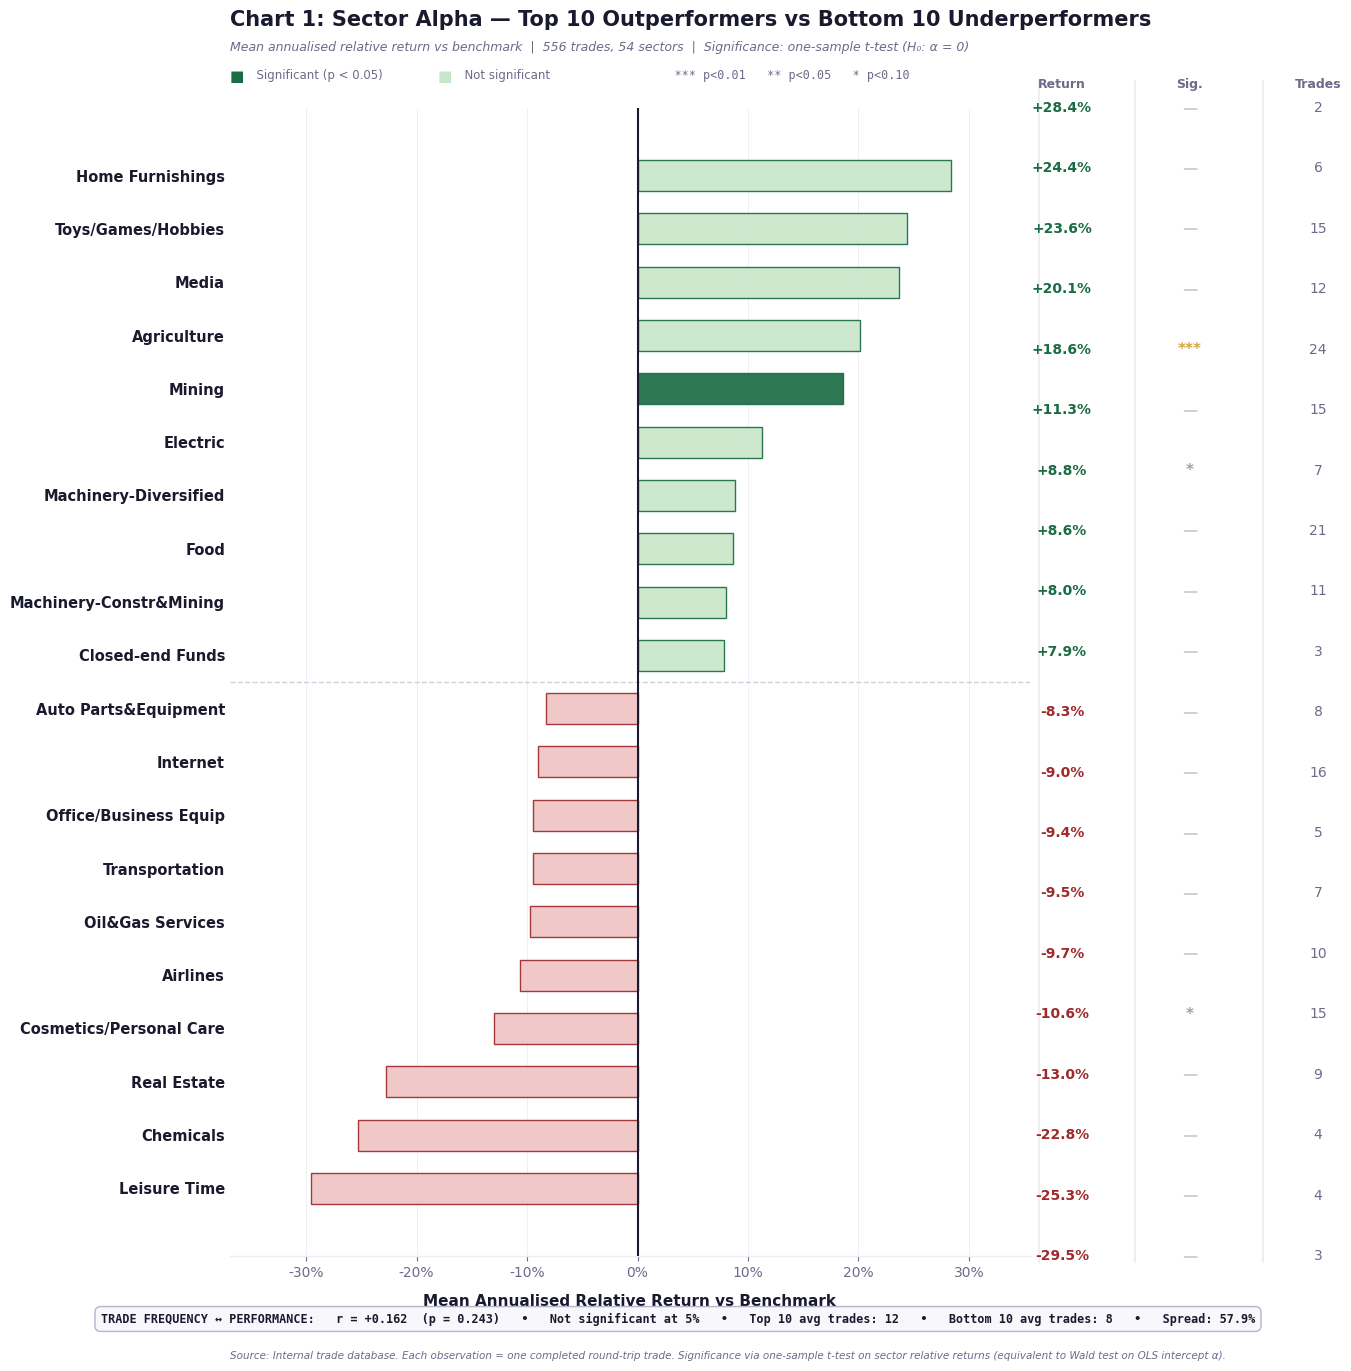

In [13]:
n_bars = len(combined)

# --- define our institutional colour palette ---
POS_DARK  = '#1B6B44'
NEG_DARK  = '#9E2A2B'
POS_LIGHT = '#C8E6C9'
NEG_LIGHT = '#F0C4C4'
TXT_PRI   = '#1A1A2E'
TXT_SEC   = '#6B6B8A'
GRID_COL  = '#EDEDF2'
DIV_COL   = '#B0B0C8'

# --- set up figure with space for annotation columns on the right ---
fig = plt.figure(figsize=(16, 14))
fig.patch.set_facecolor('white')

ax = fig.add_axes([0.22, 0.08, 0.50, 0.82])
ax.set_facecolor('white')

sectors = combined.index.tolist()
returns = combined['Mean_Return'].values
counts  = combined['Trade_Count'].values.astype(int)
y_pos   = np.arange(n_bars)

# --- draw the horizontal bars ---
for i, sector in enumerate(sectors):
    ret = returns[i]
    is_sig = combined.loc[sector, 'sig_05']

    if ret >= 0:
        fc = POS_DARK if is_sig else POS_LIGHT
        ec = POS_DARK
    else:
        fc = NEG_DARK if is_sig else NEG_LIGHT
        ec = NEG_DARK

    ax.barh(i, ret, height=0.58, color=fc, edgecolor=ec,
            linewidth=1.0, alpha=0.92, zorder=3)

ax.axvline(x=0, color=TXT_PRI, linewidth=1.5, zorder=4)
ax.axhline(y=9.5, color=DIV_COL, linewidth=1.0, linestyle='--', zorder=2, alpha=0.6)

ax.set_yticks(y_pos)
ax.set_yticklabels(sectors, fontsize=10.5, fontweight='bold', color=TXT_PRI)
ax.invert_yaxis()

ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.tick_params(axis='x', colors=TXT_SEC, labelsize=10)
ax.tick_params(axis='y', length=0)
ax.set_xlabel('Mean Annualised Relative Return vs Benchmark',
              fontsize=11, fontweight='bold', color=TXT_PRI, labelpad=10)

ax.grid(axis='x', color=GRID_COL, linewidth=0.6, zorder=1)
ax.set_axisbelow(True)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_color(GRID_COL)
ax.spines['bottom'].set_linewidth(1.0)

x_min = min(returns) * 1.25
x_max = max(returns) * 1.25
ax.set_xlim(x_min, x_max)

# --- RIGHT-SIDE ANNOTATION COLUMNS ---
col_return_x = 0.74
col_sig_x    = 0.82
col_n_x      = 0.90

header_y = 0.08 + 0.82 + 0.012
fig.text(col_return_x, header_y, 'Return', fontsize=9, fontweight='bold',
         color=TXT_SEC, ha='center', va='bottom')
fig.text(col_sig_x, header_y, 'Sig.', fontsize=9, fontweight='bold',
         color=TXT_SEC, ha='center', va='bottom')
fig.text(col_n_x, header_y, 'Trades', fontsize=9, fontweight='bold',
         color=TXT_SEC, ha='center', va='bottom')

ax_bottom = 0.08
ax_height = 0.82

for i, sector in enumerate(sectors):
    ret = returns[i]
    count = counts[i]
    p_val = combined.loc[sector, 'p_value']

    frac = (i) / (n_bars - 1) if n_bars > 1 else 0.5
    fig_y = ax_bottom + ax_height * (1.0 - frac)

    ret_color = POS_DARK if ret >= 0 else NEG_DARK
    fig.text(col_return_x, fig_y, f'{ret:+.1%}', fontsize=10, fontweight='bold',
             color=ret_color, ha='center', va='center')

    if pd.notna(p_val):
        if p_val < 0.01:   stars, s_col = '***', '#D4A843'
        elif p_val < 0.05: stars, s_col = '**', '#D4A843'
        elif p_val < 0.10: stars, s_col = '*', '#A0A0B0'
        else:              stars, s_col = '—', '#D0D0D8'
    else:
        stars, s_col = '—', '#D0D0D8'

    fig.text(col_sig_x, fig_y, stars, fontsize=11, fontweight='bold',
             color=s_col, ha='center', va='center')
    fig.text(col_n_x, fig_y, str(count), fontsize=10, color=TXT_SEC,
             ha='center', va='center')

for x_sep in [0.725, 0.785, 0.865]:
    fig.patches.append(plt.Rectangle(
        (x_sep, ax_bottom - 0.005), 0.001, ax_height + 0.025,
        transform=fig.transFigure, facecolor=GRID_COL, edgecolor='none', zorder=0))

fig.text(0.22, 0.97,
         'Chart 1: Sector Alpha — Top 10 Outperformers vs Bottom 10 Underperformers',
         fontsize=15, fontweight='bold', color=TXT_PRI, ha='left', va='top')
fig.text(0.22, 0.948,
         'Mean annualised relative return vs benchmark  |  556 trades, 54 sectors  |  '
         'Significance: one-sample t-test (H₀: α = 0)',
         fontsize=9, color=TXT_SEC, ha='left', va='top', style='italic')

box_text = (
    f'TRADE FREQUENCY ↔ PERFORMANCE:   '
    f'r = {corr:+.3f}  (p = {corr_p:.3f})   •   '
    f'{"Significant" if corr_p < 0.05 else "Not significant"} at 5%   •   '
    f'Top 10 avg trades: {top_10["Trade_Count"].mean():.0f}   •   '
    f'Bottom 10 avg trades: {bottom_10["Trade_Count"].mean():.0f}   •   '
    f'Spread: {returns[0] - returns[-1]:.1%}'
)
fig.text(0.50, 0.035, box_text, fontsize=8.5, ha='center', va='center',
         fontfamily='monospace', fontweight='bold', color=TXT_PRI,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#F7F7FC',
                   edgecolor=DIV_COL, linewidth=1.0, alpha=0.95))

legend_items = [
    ('■', POS_DARK, '  Significant (p < 0.05)'),
    ('■', POS_LIGHT, '  Not significant'),
    ('', '', '    *** p<0.01   ** p<0.05   * p<0.10'),
]
leg_x = 0.22
for sym, col, label in legend_items:
    if sym:
        fig.text(leg_x, 0.928, sym, fontsize=11, color=col, ha='left',
                 va='top', fontweight='bold')
        fig.text(leg_x + 0.012, 0.928, label, fontsize=8.5, color=TXT_SEC,
                 ha='left', va='top')
        leg_x += 0.13
    else:
        fig.text(leg_x, 0.928, label, fontsize=8.5, color=TXT_SEC,
                 ha='left', va='top', fontfamily='monospace')

fig.text(0.22, 0.005,
         'Source: Internal trade database. Each observation = one completed round-trip trade. '
         'Significance via one-sample t-test on sector relative returns '
         '(equivalent to Wald test on OLS intercept α).',
         fontsize=7.5, color=TXT_SEC, ha='left', va='bottom', style='italic')

plt.savefig('sector_performance_institutional.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

### 2.3 Sector Performance — Console Summary

Let's also print a clean tabular summary for reference. This is useful for the written report and makes it easy to double-check the chart values.

In [14]:
print("\n" + "=" * 100)
print("EXHIBIT 1: SECTOR ALPHA — STATISTICAL SUMMARY")
print("=" * 100)
print(f"\n{'Sector':<45} {'Return':>8} {'n':>5} {'t-stat':>8} {'p-val':>9} {'Sig':>6}")
print("-" * 85)

for i, sector in enumerate(combined.index):
    r = combined.loc[sector]
    stars = '***' if r['sig_01'] else ('**' if r['sig_05'] else ('*' if r['sig_10'] else ''))
    t = f"{r['t_stat']:.2f}" if pd.notna(r['t_stat']) else 'n/a'
    p = f"{r['p_value']:.4f}" if pd.notna(r['p_value']) else 'n/a'
    print(f"{sector:<45} {r['Mean_Return']:>+7.2%} {int(r['Trade_Count']):>5} {t:>8} {p:>9} {stars:>6}")
    if i == 9:
        print("-" * 85)

print("-" * 85)
print(f"\nCorrelation (frequency vs return):  r = {corr:+.3f}  (p = {corr_p:.3f})")
print(f"Sectors significant at 5%: {combined['sig_05'].sum()}/{len(combined)}")
print(f"Sectors significant at 10%: {combined['sig_10'].sum()}/{len(combined)}")
print("=" * 100)


EXHIBIT 1: SECTOR ALPHA — STATISTICAL SUMMARY

Sector                                          Return     n   t-stat     p-val    Sig
-------------------------------------------------------------------------------------
Home Furnishings                              +28.42%     2      n/a       n/a       
Toys/Games/Hobbies                            +24.37%     6     1.32    0.2440       
Media                                         +23.65%    15     1.49    0.1575       
Agriculture                                   +20.15%    12     1.02    0.3299       
Mining                                        +18.59%    24     3.21    0.0039    ***
Electric                                      +11.25%    15     1.60    0.1325       
Machinery-Diversified                          +8.80%     7     2.28    0.0632      *
Food                                           +8.61%    21     0.93    0.3657       
Machinery-Constr&Mining                        +8.05%    11     1.75    0.1110       
Close

---
## 3. Temporal Performance

Has our trading performance changed over time? Are there cyclical patterns or structural breaks?

To investigate this, we:
- Aggregate returns by **quarter** and compute a **rolling 1-year average**
- Apply **cubic spline interpolation** to smooth the curve for clearer visual patterns
- Identify **performance regimes** — sustained periods of outperformance or underperformance
- Calculate win rate and average return within each regime

### 3.1 Prepare Temporal Data

First, we need to convert the buy dates to proper datetime format and calculate quarterly performance averages. The rolling 1-year window smooths out quarter-to-quarter noise.

In [15]:
df_temp = df.copy()

df_temp['First Buy'] = pd.to_datetime(df_temp['First Buy'])
df_temp['Year'] = df_temp['First Buy'].dt.year
df_temp['Quarter'] = df_temp['First Buy'].dt.to_period('Q')

quarterly_perf = df_temp.groupby('Quarter').agg({
    "Rel return Ann'd": 'mean',
    'Hit/Miss': 'count'
}).reset_index()

quarterly_perf['Date'] = quarterly_perf['Quarter'].dt.to_timestamp()
quarterly_perf = quarterly_perf.sort_values('Date')

quarterly_perf['Rolling_1Y_Return'] = (
    quarterly_perf["Rel return Ann'd"]
    .rolling(window=4, min_periods=2)
    .mean()
)

print(f"Quarters covered: {len(quarterly_perf)}")
print(f"Date range: {quarterly_perf['Date'].min().strftime('%Y-Q1')} to {quarterly_perf['Date'].max().strftime('%Y-Q4')}")

Quarters covered: 78
Date range: 2005-Q1 to 2025-Q4


### 3.2 Smooth the Curve & Identify Regimes

We use cubic spline interpolation to create a smooth performance curve, which makes visual patterns (cycles, structural breaks) much easier to identify. We then define a simple regime-detection function that finds sustained periods above or below zero.

In [16]:
dates_num = np.arange(len(quarterly_perf))
dates = quarterly_perf['Date']
returns_ts = quarterly_perf['Rolling_1Y_Return'].fillna(0)

if len(dates_num) > 3:
    spl = make_interp_spline(dates_num, returns_ts, k=3)
    dates_smooth = np.linspace(dates_num.min(), dates_num.max(), 300)
    returns_smooth = spl(dates_smooth)

    dates_smooth_actual = [
        dates.iloc[0] + (dates.iloc[-1] - dates.iloc[0]) * (i / len(dates_smooth))
        for i in range(len(dates_smooth))
    ]
else:
    dates_smooth_actual = dates
    returns_smooth = returns_ts

positive_mask = returns_smooth > 0
negative_mask = returns_smooth <= 0

In [17]:
def find_regimes(dates, returns, threshold=0):
    """Identify continuous periods where the strategy is above or below the threshold."""
    regimes = []
    current_regime = None
    regime_start = None

    for i, (date, ret) in enumerate(zip(dates, returns)):
        if ret > threshold:
            if current_regime != 'positive':
                if current_regime == 'negative' and regime_start is not None:
                    regimes.append(('negative', regime_start, dates[i-1]))
                current_regime = 'positive'
                regime_start = date
        else:
            if current_regime != 'negative':
                if current_regime == 'positive' and regime_start is not None:
                    regimes.append(('positive', regime_start, dates[i-1]))
                current_regime = 'negative'
                regime_start = date

    if current_regime and regime_start:
        regimes.append((current_regime, regime_start, dates[-1]))

    return regimes

regimes = find_regimes(dates_smooth_actual, returns_smooth)
print(f"Detected {len(regimes)} performance regimes")

Detected 18 performance regimes


### 3.3 Chart 2: Performance Cycles Chart

The chart uses a Schroders-inspired area chart style: light blue for periods of outperformance, dark blue for underperformance. Regime durations are annotated directly on the chart.

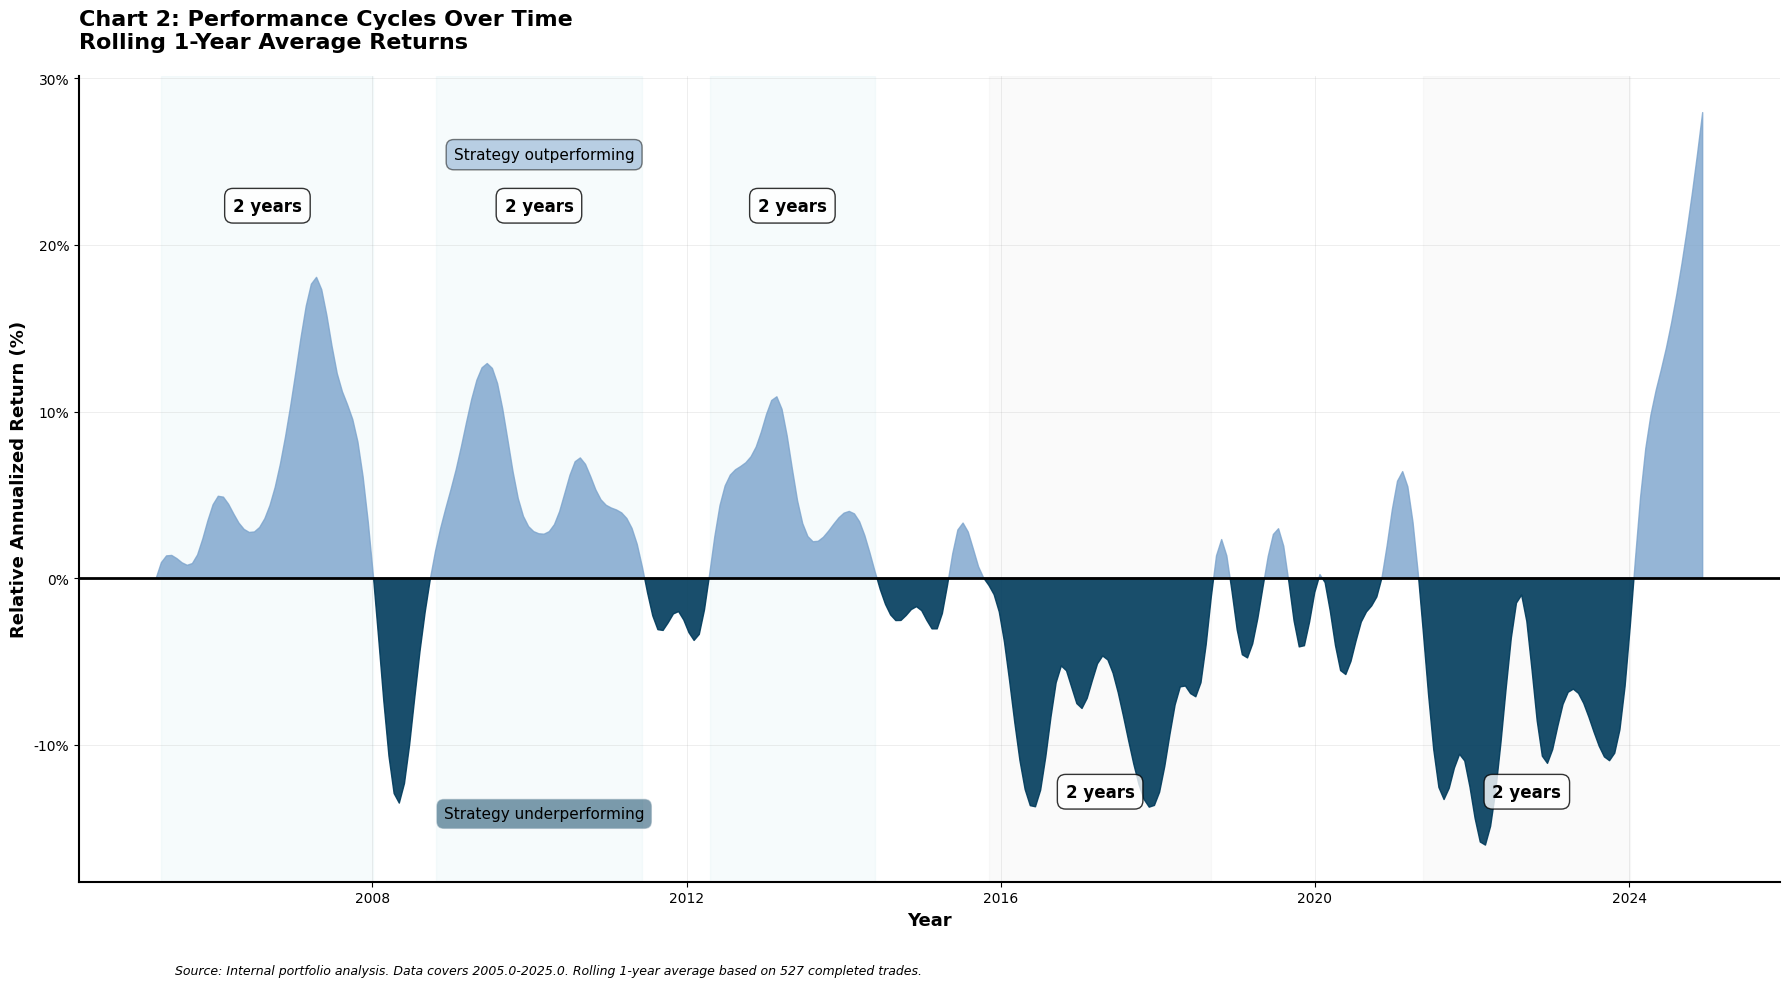

In [18]:
fig, ax = plt.subplots(figsize=(18, 10))

ax.fill_between(dates_smooth_actual, 0, returns_smooth,
                where=positive_mask, interpolate=True,
                color='#7BA3CC', alpha=0.8, label='Outperforming')

ax.fill_between(dates_smooth_actual, 0, returns_smooth,
                where=negative_mask, interpolate=True,
                color='#003B5C', alpha=0.9, label='Underperforming')

ax.axhline(y=0, color='black', linewidth=2, zorder=3)

for regime_type, start, end in regimes:
    duration_years = (end - start).days / 365.25
    if duration_years > 1:
        mid_date = start + (end - start) / 2
        mid_idx = int(len(dates_smooth_actual) * (
            (mid_date - dates_smooth_actual[0]) /
            (dates_smooth_actual[-1] - dates_smooth_actual[0])
        ))
        mid_idx = max(0, min(mid_idx, len(returns_smooth) - 1))

        ax.axvspan(start, end, alpha=0.1,
                   color='lightblue' if regime_type == 'positive' else 'lightgray',
                   zorder=0)

        y_pos_ann = (max(abs(returns_smooth)) * 0.8
                     if regime_type == 'positive'
                     else min(returns_smooth) * 0.8)
        ax.text(mid_date, y_pos_ann, f'{int(duration_years)} years',
                ha='center', va='center', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                          edgecolor='black', alpha=0.8))

ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Relative Annualized Return (%)', fontsize=13, fontweight='bold')
ax.set_title('Chart 2: Performance Cycles Over Time\nRolling 1-Year Average Returns',
             fontsize=16, fontweight='bold', pad=20, loc='left')

y_max = max(returns_smooth)
y_min = min(returns_smooth)
ax.text(dates_smooth_actual[len(dates_smooth_actual)//4], y_max * 0.9,
        'Strategy outperforming', fontsize=11, ha='center',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#7BA3CC', alpha=0.5))
ax.text(dates_smooth_actual[len(dates_smooth_actual)//4], y_min * 0.9,
        'Strategy underperforming', fontsize=11, ha='center',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#003B5C', alpha=0.5,
                  edgecolor='white'))

ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

source_text = (f"Source: Internal portfolio analysis. "
               f"Data covers {df_temp['Year'].min()}-{df_temp['Year'].max()}. "
               f"Rolling 1-year average based on {len(df)} completed trades.")
fig.text(0.1, 0.02, source_text, fontsize=9, style='italic', wrap=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('performance_cycles_schroder_style.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.4 Regime Summary

Let us print a detailed summary of each detected regime, including the number of trades, average return, and win rate.

In [19]:
print("\n" + "="*80)
print("PERFORMANCE REGIME ANALYSIS")
print("="*80)

for i, (regime_type, start, end) in enumerate(regimes, 1):
    duration_years = (end - start).days / 365.25
    if duration_years > 0.5:
        print(f"\nRegime {i}: {regime_type.upper()}")
        print(f"  Duration: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')} ({duration_years:.1f} years)")

        regime_trades = df_temp[
            (df_temp['First Buy'] >= start) & (df_temp['First Buy'] <= end)
        ]

        if len(regime_trades) > 0:
            print(f"  Trades: {len(regime_trades)}")
            print(f"  Avg Return: {regime_trades['Rel return Ann\'d'].mean():.2%}")
            print(f"  Win Rate: {(regime_trades['Hit/Miss'] == 'Hit').mean():.1%}")

print("\n" + "="*80)


PERFORMANCE REGIME ANALYSIS

Regime 2: POSITIVE
  Duration: 2005-04-25 to 2008-01-06 (2.7 years)
  Trades: 96
  Avg Return: 1.53%
  Win Rate: 54.2%

Regime 3: NEGATIVE
  Duration: 2008-01-30 to 2008-09-26 (0.7 years)
  Trades: 14
  Avg Return: -5.74%
  Win Rate: 57.1%

Regime 4: POSITIVE
  Duration: 2008-10-20 to 2011-06-09 (2.6 years)
  Trades: 96
  Avg Return: 9.34%
  Win Rate: 54.2%

Regime 5: NEGATIVE
  Duration: 2011-07-03 to 2012-03-24 (0.7 years)
  Trades: 44
  Avg Return: -3.25%
  Win Rate: 38.6%

Regime 6: POSITIVE
  Duration: 2012-04-17 to 2014-05-26 (2.1 years)
  Trades: 49
  Avg Return: 5.53%
  Win Rate: 61.2%

Regime 7: NEGATIVE
  Duration: 2014-06-20 to 2015-04-28 (0.9 years)
  Trades: 23
  Avg Return: 0.45%
  Win Rate: 52.2%

Regime 9: NEGATIVE
  Duration: 2015-11-07 to 2018-09-06 (2.8 years)
  Trades: 52
  Avg Return: -4.82%
  Win Rate: 38.5%

Regime 15: NEGATIVE
  Duration: 2020-02-17 to 2020-10-14 (0.7 years)
  Trades: 21
  Avg Return: 0.06%
  Win Rate: 38.1%

Regime

---
## 4. Geographic Analysis

Do we perform better in certain regions? Are there geographies we should tilt towards or avoid?

We map each Bloomberg country code to a broader region and then apply three layers of statistical testing:
- **ANOVA** — are regional means *jointly* different from each other?
- **One-sample t-test** per region — does each region's alpha differ from zero?
- **Mann-Whitney U** — does the distribution of returns differ between the best and worst regions?

### 4.1 Map Countries to Regions & Aggregate

In [20]:
country_code_mapping = {
    'US': 'North America', 'CA': 'North America', 'MX': 'North America',
    'GB': 'Europe', 'GE': 'Europe', 'FR': 'Europe', 'SZ': 'Europe',
    'NE': 'Europe', 'SW': 'Europe', 'NO': 'Europe', 'DE': 'Europe',
    'IT': 'Europe', 'SP': 'Europe', 'FI': 'Europe', 'IR': 'Europe',
    'PO': 'Europe', 'GR': 'Europe', 'RU': 'Europe', 'TU': 'Europe',
    'LX': 'Europe', 'UA': 'Europe',
    'JN': 'Asia-Pacific', 'HK': 'Asia-Pacific', 'SI': 'Asia-Pacific',
    'SK': 'Asia-Pacific', 'TA': 'Asia-Pacific', 'AU': 'Asia-Pacific',
    'CC': 'Asia-Pacific', 'TH': 'Asia-Pacific', 'IN': 'Asia-Pacific',
    'ID': 'Asia-Pacific', 'PH': 'Asia-Pacific', 'BD': 'Asia-Pacific',
    'BZ': 'Latin America', 'PE': 'Latin America', 'CH': 'Latin America',
    'SA': 'Middle East & Africa', 'JE': 'Middle East & Africa',
    'MA': 'Middle East & Africa', 'GS': 'Middle East & Africa',
}

df_clean = df[df['Country'].notna()].copy()
df_clean['Region'] = df_clean['Country'].map(country_code_mapping).fillna('Other')

regional_perf = df_clean.groupby('Region').agg(
    Mean_Alpha=("Rel return Ann'd", 'mean'),
    Median_Alpha=("Rel return Ann'd", 'median'),
    Std_Alpha=("Rel return Ann'd", 'std'),
    Trade_Count=("Rel return Ann'd", 'count'),
    Hit_Rate=('Hit/Miss', lambda x: (x == 'Hit').mean()),
    Num_Countries=('Country', 'nunique')
).round(4)

regional_perf = regional_perf.sort_values('Mean_Alpha', ascending=True)
regional_perf

,Mean_Alpha,Median_Alpha,Std_Alpha,Trade_Count,Hit_Rate,Num_Countries
Region,,,,,,
Middle East & Africa,-0.0159,-0.0783,0.1776,7,0.2857,4
Other,-0.0090,-0.0090,NaN,1,0.0000,1
Europe,0.0012,-0.0121,0.2106,258,0.4690,18
Latin America,0.0122,-0.0674,0.3636,10,0.4000,3
North America,0.0213,0.0130,0.3414,111,0.5766,3
Asia-Pacific,0.0331,-0.0158,0.3408,138,0.4493,12


### 4.2 Statistical Testing

In [21]:
# --- (a) ANOVA: are regional mean returns jointly different? ---
regional_groups = []
region_labels = []
for region in regional_perf.index:
    grp = df_clean.loc[df_clean['Region'] == region, "Rel return Ann'd"].dropna()
    if len(grp) >= 3:
        regional_groups.append(grp)
        region_labels.append(region)

f_stat, p_anova = f_oneway(*regional_groups) if len(regional_groups) > 2 else (0, 1)

# --- (b) per-region t-test ---
for region in regional_perf.index:
    rets = df_clean.loc[df_clean['Region'] == region, "Rel return Ann'd"].dropna()
    if len(rets) >= 3:
        t, p = ttest_1samp(rets, 0)
        regional_perf.loc[region, 't_stat'] = t
        regional_perf.loc[region, 'p_value'] = p
    else:
        regional_perf.loc[region, 't_stat'] = np.nan
        regional_perf.loc[region, 'p_value'] = np.nan

regional_perf['sig_05'] = regional_perf['p_value'] < 0.05
regional_perf['sig_10'] = regional_perf['p_value'] < 0.10

# --- (c) Mann-Whitney U: best region vs worst region ---
best_region = regional_perf.index[-1]
worst_region = regional_perf.index[0]
best_rets = df_clean.loc[df_clean['Region'] == best_region, "Rel return Ann'd"].dropna()
worst_rets = df_clean.loc[df_clean['Region'] == worst_region, "Rel return Ann'd"].dropna()

if len(best_rets) >= 3 and len(worst_rets) >= 3:
    u_stat, p_mw = mannwhitneyu(best_rets, worst_rets, alternative='two-sided')
else:
    u_stat, p_mw = np.nan, np.nan

print(f"ANOVA: F={f_stat:.2f}, p={p_anova:.4f}")
print(f"Best region: {best_region} | Worst region: {worst_region}")
if pd.notna(p_mw):
    print(f"Mann-Whitney U ({best_region} vs {worst_region}): U={u_stat:.0f}, p={p_mw:.4f}")

ANOVA: F=0.33, p=0.8596
Best region: Asia-Pacific | Worst region: Middle East & Africa
Mann-Whitney U (Asia-Pacific vs Middle East & Africa): U=529, p=0.6747


### 4.3 Chart 3: Geographic Alpha Chart

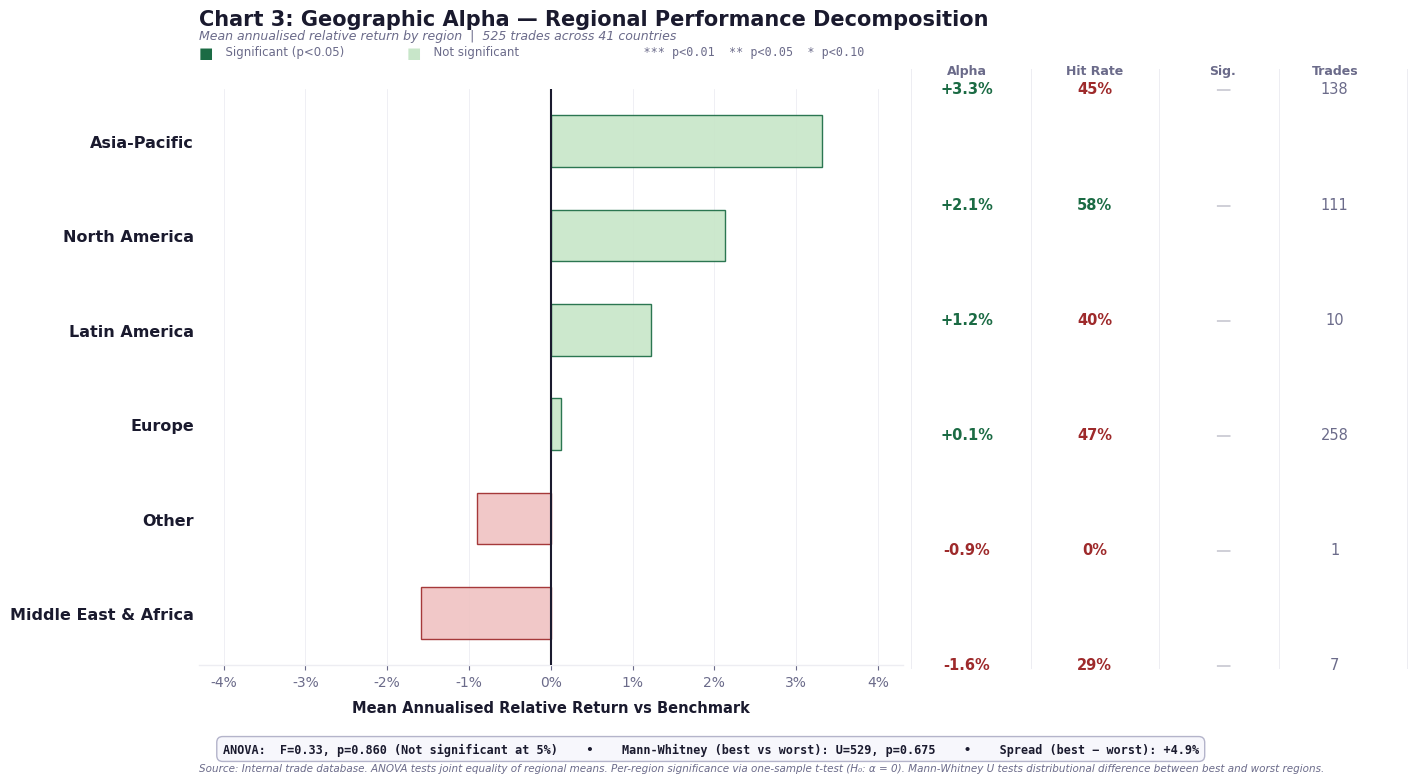

In [22]:
n_bars = len(regional_perf)

POS_DARK  = '#1B6B44'
NEG_DARK  = '#9E2A2B'
POS_LIGHT = '#C8E6C9'
NEG_LIGHT = '#F0C4C4'
TXT_PRI   = '#1A1A2E'
TXT_SEC   = '#6B6B8A'
GRID_COL  = '#EDEDF2'
DIV_COL   = '#B0B0C8'
GOLD      = '#D4A843'

fig = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

ax = fig.add_axes([0.18, 0.14, 0.44, 0.72])
ax.set_facecolor('white')

regions = regional_perf.index.tolist()
alphas  = regional_perf['Mean_Alpha'].values
counts  = regional_perf['Trade_Count'].values.astype(int)
y_pos   = np.arange(n_bars)

for i, region in enumerate(regions):
    ret = alphas[i]
    is_sig = regional_perf.loc[region, 'sig_05']

    if ret >= 0:
        fc = POS_DARK if is_sig else POS_LIGHT
        ec = POS_DARK
    else:
        fc = NEG_DARK if is_sig else NEG_LIGHT
        ec = NEG_DARK

    ax.barh(i, ret, height=0.55, color=fc, edgecolor=ec,
            linewidth=1.0, alpha=0.92, zorder=3)

ax.axvline(x=0, color=TXT_PRI, linewidth=1.5, zorder=4)

ax.set_yticks(y_pos)
ax.set_yticklabels(regions, fontsize=11.5, fontweight='bold', color=TXT_PRI)

x_pad = max(abs(alphas.min()), abs(alphas.max())) * 1.3
ax.set_xlim(-x_pad, x_pad)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.tick_params(axis='x', colors=TXT_SEC, labelsize=10)
ax.tick_params(axis='y', length=0)
ax.set_xlabel('Mean Annualised Relative Return vs Benchmark',
              fontsize=10.5, fontweight='bold', color=TXT_PRI, labelpad=8)

ax.grid(axis='x', color=GRID_COL, linewidth=0.6, zorder=1)
ax.set_axisbelow(True)
for sp in ['top', 'right', 'left']:
    ax.spines[sp].set_visible(False)
ax.spines['bottom'].set_color(GRID_COL)
ax.spines['bottom'].set_linewidth(1.0)

# --- RIGHT-SIDE ANNOTATION TABLE ---
col_ret_x  = 0.66
col_hr_x   = 0.74
col_sig_x  = 0.82
col_n_x    = 0.89

ax_bottom = 0.14
ax_height = 0.72
header_y  = ax_bottom + ax_height + 0.015

for x, lbl in [(col_ret_x, 'Alpha'), (col_hr_x, 'Hit Rate'),
               (col_sig_x, 'Sig.'), (col_n_x, 'Trades')]:
    fig.text(x, header_y, lbl, fontsize=9, fontweight='bold',
             color=TXT_SEC, ha='center', va='bottom')

for x_sep in [0.625, 0.70, 0.78, 0.855, 0.935]:
    fig.patches.append(plt.Rectangle(
        (x_sep, ax_bottom - 0.005), 0.001, ax_height + 0.03,
        transform=fig.transFigure, facecolor=GRID_COL, edgecolor='none', zorder=0))

for i, region in enumerate(regions):
    frac = i / (n_bars - 1) if n_bars > 1 else 0.5
    fig_y = ax_bottom + ax_height * frac

    row = regional_perf.loc[region]
    ret = row['Mean_Alpha']
    ret_col = POS_DARK if ret >= 0 else NEG_DARK

    fig.text(col_ret_x, fig_y, f'{ret:+.1%}', fontsize=10.5, fontweight='bold',
             color=ret_col, ha='center', va='center')

    hr = row['Hit_Rate']
    hr_col = POS_DARK if hr >= 0.50 else NEG_DARK
    fig.text(col_hr_x, fig_y, f'{hr:.0%}', fontsize=10.5, fontweight='bold',
             color=hr_col, ha='center', va='center')

    p = row['p_value']
    if pd.notna(p):
        if p < 0.01:    stars, sc = '***', GOLD
        elif p < 0.05:  stars, sc = '**', GOLD
        elif p < 0.10:  stars, sc = '*', '#A0A0B0'
        else:           stars, sc = '—', '#D0D0D8'
    else:
        stars, sc = '—', '#D0D0D8'
    fig.text(col_sig_x, fig_y, stars, fontsize=11, fontweight='bold',
             color=sc, ha='center', va='center')

    fig.text(col_n_x, fig_y, str(int(row['Trade_Count'])), fontsize=10.5,
             color=TXT_SEC, ha='center', va='center')

fig.text(0.18, 0.96,
         'Chart 3: Geographic Alpha — Regional Performance Decomposition',
         fontsize=15, fontweight='bold', color=TXT_PRI, ha='left', va='top')
fig.text(0.18, 0.935,
         'Mean annualised relative return by region  |  '
         f'{int(regional_perf["Trade_Count"].sum())} trades across '
         f'{int(regional_perf["Num_Countries"].sum())} countries',
         fontsize=9, color=TXT_SEC, ha='left', va='top', style='italic')

leg_x = 0.18
items = [('■', POS_DARK, '  Significant (p<0.05)'),
         ('■', POS_LIGHT, '  Not significant'),
         ('', '', '    *** p<0.01  ** p<0.05  * p<0.10')]
for sym, col, lbl in items:
    if sym:
        fig.text(leg_x, 0.915, sym, fontsize=11, color=col, fontweight='bold',
                 ha='left', va='top')
        fig.text(leg_x + 0.012, 0.915, lbl, fontsize=8.5, color=TXT_SEC,
                 ha='left', va='top')
        leg_x += 0.13
    else:
        fig.text(leg_x, 0.915, lbl, fontsize=8.5, color=TXT_SEC,
                 ha='left', va='top', fontfamily='monospace')

anova_sig = 'Significant' if p_anova < 0.05 else 'Not significant'
mw_txt = f'Mann-Whitney (best vs worst): U={u_stat:.0f}, p={p_mw:.3f}' if pd.notna(p_mw) else ''
stats_line = (
    f'ANOVA:  F={f_stat:.2f}, p={p_anova:.3f} ({anova_sig} at 5%)'
    f'    •    {mw_txt}'
    f'    •    Spread (best − worst): {alphas[-1] - alphas[0]:+.1%}'
)
fig.text(0.50, 0.035, stats_line, fontsize=8.5, ha='center', va='center',
         fontfamily='monospace', fontweight='bold', color=TXT_PRI,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#F7F7FC',
                   edgecolor=DIV_COL, linewidth=1.0, alpha=0.95))

fig.text(0.18, 0.005,
         'Source: Internal trade database. ANOVA tests joint equality of regional means. '
         'Per-region significance via one-sample t-test (H₀: α = 0). '
         'Mann-Whitney U tests distributional difference between best and worst regions.',
         fontsize=7.5, color=TXT_SEC, ha='left', va='bottom', style='italic')

plt.savefig('geographic_performance_institutional.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

### 4.4 Geographic Performance — Console Summary

In [23]:
print("\n" + "=" * 100)
print("Chart 2: GEOGRAPHIC ALPHA — STATISTICAL SUMMARY")
print("=" * 100)

print(f"\n{'Region':<25} {'Alpha':>8} {'Hit Rate':>10} {'n':>6} {'t-stat':>8} {'p-val':>9} {'Sig':>5}")
print("-" * 75)

for region in regional_perf.sort_values('Mean_Alpha', ascending=False).index:
    r = regional_perf.loc[region]
    stars = '***' if r['p_value'] < 0.01 else ('**' if r['sig_05'] else ('*' if r['sig_10'] else ''))
    t = f"{r['t_stat']:.2f}" if pd.notna(r['t_stat']) else 'n/a'
    p = f"{r['p_value']:.4f}" if pd.notna(r['p_value']) else 'n/a'
    print(f"{region:<25} {r['Mean_Alpha']:>+7.2%} {r['Hit_Rate']:>9.0%} "
          f"{int(r['Trade_Count']):>6} {t:>8} {p:>9} {stars:>5}")

print("-" * 75)
print(f"\nANOVA:  F = {f_stat:.2f},  p = {p_anova:.4f}  →  {anova_sig}")
if pd.notna(p_mw):
    print(f"Mann-Whitney ({best_region} vs {worst_region}):  U = {u_stat:.0f},  p = {p_mw:.4f}")
print("=" * 100)


Chart 2: GEOGRAPHIC ALPHA — STATISTICAL SUMMARY

Region                       Alpha   Hit Rate      n   t-stat     p-val   Sig
---------------------------------------------------------------------------
Asia-Pacific               +3.31%       45%    138     1.14    0.2556      
North America              +2.13%       58%    111     0.66    0.5114      
Latin America              +1.22%       40%     10     0.11    0.9180      
Europe                     +0.12%       47%    258     0.09    0.9245      
Other                      -0.90%        0%      1      n/a       n/a      
Middle East & Africa       -1.59%       29%      7    -0.24    0.8202      
---------------------------------------------------------------------------

ANOVA:  F = 0.33,  p = 0.8596  →  Not significant
Mann-Whitney (Asia-Pacific vs Middle East & Africa):  U = 529,  p = 0.6747


---
## 5. Multi-Factor Analysis

This is the most important section — it brings together valuation, growth, and profitability metrics into a single model to identify the 2–3 factors most predictive of trade success.

**Methodology:**
- All features are **standardised** (zero mean, unit variance) so coefficients are comparable
- We first diagnose **multicollinearity** using Variance Inflation Factors (VIF) and iteratively remove the most collinear variable until all VIFs fall below the threshold
- We then fit a **logistic regression** with **HC3 robust standard errors** on the reduced, non-collinear feature set
- **Average marginal effects** give us an intuitive interpretation
- **Joint Wald tests** by category tell us whether valuation, growth, and profitability are collectively significant

### 5.1 Configure Candidate Metrics

We define the full set of candidate metrics for the model. Each is tagged with its category and a clean display name. Column names are matched exactly to the Excel file headers.

In [24]:
# CORRECTED: column names now match the Excel file exactly
metrics_config = {
    'Price to Earnings':            ('Valuation',     'P/E Ratio'),
    'Price to Book':                ('Valuation',     'P/B Ratio'),
    'EV/\nEBITDA':                  ('Valuation',     'EV/EBITDA'),
    'Price to Sales':               ('Valuation',     'P/Sales'),
    'Sales_Growth_1_Year':          ('Growth',        'Sales Growth (1Y)'),
    'EPS - 1 Yr Growth':            ('Growth',        'EPS Growth (1Y)'),
    'Free Cash Flow 1 Year Growth': ('Growth',        'FCF Growth (1Y)'),
    'Return on Common Equity':      ('Profitability', 'ROE'),
    'Return on Assets':             ('Profitability', 'ROA'),
    'EBIT Margin':                  ('Profitability', 'EBIT Margin'),
    'Return on Invested Capital':   ('Profitability', 'ROIC'),
}

# check which columns actually exist in our dataset
feature_cols = [c for c in metrics_config.keys() if c in df.columns]
missing_cols = [c for c in metrics_config.keys() if c not in df.columns]

if missing_cols:
    print(f"⚠ Columns not found in dataset (skipped): {missing_cols}")
print(f"Using {len(feature_cols)} candidate metrics")

Using 11 candidate metrics


### 5.2 Build Modelling Dataset

Bloomberg data often has "n.a." strings instead of proper NaN values, so we need to clean these first. We then build a complete-cases dataset for the logistic regression.

In [25]:
# clean Bloomberg-style missing value strings
for col in feature_cols:
    df[col] = pd.to_numeric(
        df[col].replace(['n.a.', 'N/A', 'N.A.', 'na', '#N/A', '-'], np.nan),
        errors='coerce'
    )

# build modelling dataset — complete cases only
df_model = df[feature_cols + ['Hit/Miss']].dropna().copy()
df_model = df_model[df_model['Hit/Miss'].isin(['Hit', 'Miss'])]

# create binary target: 1 = Hit, 0 = Miss
df_model['Hit'] = (df_model['Hit/Miss'] == 'Hit').astype(int)

print(f"Model dataset: {len(df_model)} trades "
      f"({df_model['Hit'].sum()} Hits, {(1 - df_model['Hit']).sum():.0f} Misses)")
print(f"Note: {len(df) - len(df_model)} trades dropped due to missing feature data")

Model dataset: 159 trades (73 Hits, 86 Misses)
Note: 368 trades dropped due to missing feature data


/tmp/ipython-input-271/2769069528.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].replace(['n.a.', 'N/A', 'N.A.', 'na', '#N/A', '-'], np.nan),


### 5.3 Multicollinearity Diagnostic — Variance Inflation Factors

Before fitting the logistic regression, we must check for **multicollinearity**. When features are highly correlated with each other (e.g. ROA and EBIT Margin, or P/E and P/B), the regression cannot cleanly separate their individual effects. This causes:
- Inflated standard errors → genuine signals appear insignificant
- Unstable, sign-flipping coefficients → nonsensical economic interpretations
- Poor out-of-sample generalisation

We use the **Variance Inflation Factor (VIF)** to diagnose this. VIF measures how much the variance of each coefficient is inflated due to linear dependence with other features:
- VIF = 1: no collinearity
- VIF = 5–10: moderate — warrants caution
- VIF > 10: severe — the coefficient is unreliable

We iteratively drop the highest-VIF variable until all remaining features fall below our threshold of 5.

In [26]:
VIF_THRESHOLD = 5  # standard threshold; some practitioners use 10

def compute_vif(X_df):
    """Compute VIF for each column in a DataFrame.
    Returns a sorted DataFrame with Feature and VIF columns."""
    vif_data = pd.DataFrame({
        'Feature': X_df.columns,
        'VIF': [variance_inflation_factor(X_df.values, i)
                for i in range(X_df.shape[1])]
    })
    return vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)


# standardise all candidate features before computing VIF
scaler_vif = StandardScaler()
X_candidates = pd.DataFrame(
    scaler_vif.fit_transform(df_model[feature_cols]),
    columns=feature_cols,
    index=df_model.index
)

# --- show the FULL VIF table before any removals ---
print("=" * 70)
print("VIF DIAGNOSTIC — ALL CANDIDATE FEATURES (before removal)")
print("=" * 70)
vif_initial = compute_vif(X_candidates)
for _, row in vif_initial.iterrows():
    display = metrics_config[row['Feature']][1]
    flag = '  ← ABOVE THRESHOLD' if row['VIF'] > VIF_THRESHOLD else ''
    print(f"  {display:.<30} VIF = {row['VIF']:>6.2f}{flag}")
print(f"\nThreshold: VIF < {VIF_THRESHOLD}")
print(f"Features above threshold: {(vif_initial['VIF'] > VIF_THRESHOLD).sum()}/{len(vif_initial)}")

VIF DIAGNOSTIC — ALL CANDIDATE FEATURES (before removal)
  P/B Ratio..................... VIF =  15.11  ← ABOVE THRESHOLD
  ROE........................... VIF =  13.68  ← ABOVE THRESHOLD
  ROIC.......................... VIF =   8.39  ← ABOVE THRESHOLD
  ROA........................... VIF =   7.55  ← ABOVE THRESHOLD
  P/Sales....................... VIF =   2.60
  EPS Growth (1Y)............... VIF =   2.09
  EBIT Margin................... VIF =   1.86
  P/E Ratio..................... VIF =   1.82
  EV/EBITDA..................... VIF =   1.56
  Sales Growth (1Y)............. VIF =   1.46
  FCF Growth (1Y)............... VIF =   1.37

Threshold: VIF < 5
Features above threshold: 4/11


In [27]:
# --- iteratively drop the highest-VIF variable until all are below threshold ---
X_reduced = X_candidates.copy()
dropped_features = []

print("\n" + "=" * 70)
print("ITERATIVE VIF REDUCTION")
print("=" * 70)

iteration = 0
while True:
    vif = compute_vif(X_reduced)
    max_vif = vif.iloc[0]['VIF']
    worst_feature = vif.iloc[0]['Feature']

    if max_vif < VIF_THRESHOLD:
        print(f"\n  ✓ All VIFs below {VIF_THRESHOLD}. Stopping.")
        break

    iteration += 1
    display = metrics_config[worst_feature][1]
    cat = metrics_config[worst_feature][0]
    print(f"\n  Iteration {iteration}: Dropping {display} ({cat}) — VIF = {max_vif:.2f}")

    dropped_features.append({
        'Feature': worst_feature, 'Display': display,
        'Category': cat, 'VIF': max_vif
    })
    X_reduced = X_reduced.drop(columns=[worst_feature])

# --- print the surviving features ---
surviving_cols = X_reduced.columns.tolist()
print(f"\n  Features dropped: {len(dropped_features)}")
print(f"  Features retained: {len(surviving_cols)}")
print("\n  Retained features:")
for col in surviving_cols:
    cat, display = metrics_config[col]
    print(f"    [{cat}] {display}")

if dropped_features:
    print("\n  Dropped features (in order):")
    for d in dropped_features:
        print(f"    [{d['Category']}] {d['Display']} (VIF = {d['VIF']:.2f})")

print("=" * 70)


ITERATIVE VIF REDUCTION

  Iteration 1: Dropping P/B Ratio (Valuation) — VIF = 15.11

  Iteration 2: Dropping ROIC (Profitability) — VIF = 6.32

  ✓ All VIFs below 5. Stopping.

  Features dropped: 2
  Features retained: 9

  Retained features:
    [Valuation] P/E Ratio
    [Valuation] EV/EBITDA
    [Valuation] P/Sales
    [Growth] Sales Growth (1Y)
    [Growth] EPS Growth (1Y)
    [Growth] FCF Growth (1Y)
    [Profitability] ROE
    [Profitability] ROA
    [Profitability] EBIT Margin

  Dropped features (in order):
    [Valuation] P/B Ratio (VIF = 15.11)
    [Profitability] ROIC (VIF = 6.32)


In [28]:
# --- confirm: show final VIF table for the retained features ---
print("\nFINAL VIF TABLE (post-reduction)")
print("-" * 50)
vif_final = compute_vif(X_reduced)
for _, row in vif_final.iterrows():
    display = metrics_config[row['Feature']][1]
    print(f"  {display:.<30} VIF = {row['VIF']:>5.2f}  ✓")
print(f"\nAll VIFs below {VIF_THRESHOLD} — no multicollinearity concerns.")


FINAL VIF TABLE (post-reduction)
--------------------------------------------------
  ROA........................... VIF =  2.19  ✓
  P/Sales....................... VIF =  2.01  ✓
  EPS Growth (1Y)............... VIF =  1.90  ✓
  EBIT Margin................... VIF =  1.76  ✓
  P/E Ratio..................... VIF =  1.62  ✓
  EV/EBITDA..................... VIF =  1.53  ✓
  Sales Growth (1Y)............. VIF =  1.46  ✓
  ROE........................... VIF =  1.42  ✓
  FCF Growth (1Y)............... VIF =  1.35  ✓

All VIFs below 5 — no multicollinearity concerns.


### 5.4 Fit Logistic Regression on Clean Feature Set

Now that we have removed collinear features, we fit the logistic regression on the reduced set. Each surviving coefficient is interpretable on its own — no sign-flipping, no inflated standard errors.

We use HC3 robust standard errors because financial return distributions are typically fat-tailed and heteroskedastic.

In [29]:
# re-standardise just the surviving features for the final model
scaler_final = StandardScaler()
X_final = pd.DataFrame(
    scaler_final.fit_transform(df_model[surviving_cols]),
    columns=surviving_cols,
    index=df_model.index
)

# add constant (intercept) for statsmodels
X_final = sm.add_constant(X_final)

y = df_model['Hit']

# fit logistic regression with HC3 robust standard errors
logit_model = sm.Logit(y, X_final)
logit_results = logit_model.fit(cov_type='HC3', disp=0)

print(logit_results.summary())

                           Logit Regression Results                           
Dep. Variable:                    Hit   No. Observations:                  159
Model:                          Logit   Df Residuals:                      149
Method:                           MLE   Df Model:                            9
Date:                Thu, 26 Feb 2026   Pseudo R-squ.:                 0.06415
Time:                        22:51:44   Log-Likelihood:                -102.64
converged:                       True   LL-Null:                       -109.68
Covariance Type:                  HC3   LLR p-value:                    0.1198
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.1695      0.164     -1.032      0.302      -0.491       0.152
Price to Earnings                0.1973      0.188      1.051      0.293     

### 5.5 Marginal Effects & Joint Wald Tests

The raw logistic coefficients are in log-odds, which aren't very intuitive. **Average marginal effects** translate these into percentage-point changes in the probability of a Hit.

We also run **joint Wald tests** for each category to determine whether Valuation, Growth, and Profitability metrics are *collectively* significant.

In [30]:
# compute average marginal effects
marginal_effects = logit_results.get_margeff()

print("AVERAGE MARGINAL EFFECTS")
print("=" * 70)
print(marginal_effects.summary())

AVERAGE MARGINAL EFFECTS
        Logit Marginal Effects       
Dep. Variable:                    Hit
Method:                          dydx
At:                           overall
                                  dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Price to Earnings                0.0449      0.042      1.068      0.286      -0.038       0.127
EV/
EBITDA                       0.0277      0.041      0.679      0.497      -0.052       0.108
Price to Sales                  -0.0313      0.058     -0.543      0.587      -0.144       0.082
Sales_Growth_1_Year              0.0535      0.035      1.537      0.124      -0.015       0.122
EPS - 1 Yr Growth               -0.0944      0.052     -1.820      0.069      -0.196       0.007
Free Cash Flow 1 Year Growth    -0.0087      0.052     -0.166      0.868      -0.111       0.094
Return on Common Equity          0.0126      0.

In [31]:
# joint Wald tests by category
print("JOINT WALD TESTS BY CATEGORY")
print("=" * 70)

param_names = list(logit_results.params.index)

for cat_name in ['Valuation', 'Growth', 'Profitability']:
    cat_cols = [c for c in surviving_cols
                if metrics_config[c][0] == cat_name]

    cat_indices = [param_names.index(c) for c in cat_cols if c in param_names]

    if not cat_indices:
        print(f"\n  {cat_name}: No features survived VIF reduction.")
        continue

    R = np.zeros((len(cat_indices), len(param_names)))
    for i, idx in enumerate(cat_indices):
        R[i, idx] = 1

    wald_test = logit_results.wald_test(R)
    f_val = float(wald_test.statistic)
    p_val = float(wald_test.pvalue)

    sig = "✓ SIGNIFICANT" if p_val < 0.05 else "✗ Not significant"
    print(f"\n  {cat_name} (joint test of {len(cat_cols)} metrics):")
    print(f"    Wald χ² = {f_val:.3f}   p-value = {p_val:.4f}   {sig}")

    for c in cat_cols:
        display = metrics_config[c][1]
        coef = logit_results.params[c]
        pv = logit_results.pvalues[c]
        print(f"      {display:.<25} β = {coef:+.4f}  p = {pv:.4f}")

JOINT WALD TESTS BY CATEGORY

  Valuation (joint test of 3 metrics):
    Wald χ² = 1.936   p-value = 0.5857   ✗ Not significant
      P/E Ratio................ β = +0.1973  p = 0.2934
      EV/EBITDA................ β = +0.1215  p = 0.4999
      P/Sales.................. β = -0.1375  p = 0.5894

  Growth (joint test of 3 metrics):
    Wald χ² = 4.751   p-value = 0.1910   ✗ Not significant
      Sales Growth (1Y)........ β = +0.2351  p = 0.1377
      EPS Growth (1Y).......... β = -0.4148  p = 0.0822
      FCF Growth (1Y).......... β = -0.0381  p = 0.8681

  Profitability (joint test of 3 metrics):
    Wald χ² = 6.430   p-value = 0.0925   ✗ Not significant
      ROE...................... β = +0.0554  p = 0.7134
      ROA...................... β = +0.3514  p = 0.2447
      EBIT Margin.............. β = +0.5370  p = 0.1862


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipython-input-271/4291554560.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_val = float(wald_test.statistic)


### 5.6 Odds Ratios

Odds ratios provide an alternative way to interpret the logistic regression coefficients. An OR > 1 means that metric *increases* the odds of a Hit; OR < 1 means it *decreases* the odds.

In [32]:
odds_ratios = np.exp(logit_results.params.drop('const'))

ci = logit_results.conf_int().drop('const')
ci_or = np.exp(ci)

print("ODDS RATIOS (per 1 SD increase) — VIF-CLEANED MODEL")
print("=" * 70)
for col in surviving_cols:
    display = metrics_config[col][1]
    oratio = odds_ratios[col]
    lo, hi = ci_or.loc[col, 0], ci_or.loc[col, 1]
    direction = "↑ Increases Hit odds" if oratio > 1 else "↓ Decreases Hit odds"
    print(f"  {display:.<25} OR = {oratio:.3f}  [{lo:.3f}, {hi:.3f}]  {direction}")

ODDS RATIOS (per 1 SD increase) — VIF-CLEANED MODEL
  P/E Ratio................ OR = 1.218  [0.843, 1.760]  ↑ Increases Hit odds
  EV/EBITDA................ OR = 1.129  [0.793, 1.607]  ↑ Increases Hit odds
  P/Sales.................. OR = 0.872  [0.529, 1.436]  ↓ Decreases Hit odds
  Sales Growth (1Y)........ OR = 1.265  [0.927, 1.725]  ↑ Increases Hit odds
  EPS Growth (1Y).......... OR = 0.660  [0.414, 1.054]  ↓ Decreases Hit odds
  FCF Growth (1Y).......... OR = 0.963  [0.614, 1.509]  ↓ Decreases Hit odds
  ROE...................... OR = 1.057  [0.786, 1.421]  ↑ Increases Hit odds
  ROA...................... OR = 1.421  [0.786, 2.569]  ↑ Increases Hit odds
  EBIT Margin.............. OR = 1.711  [0.772, 3.793]  ↑ Increases Hit odds


### 5.7 Chart 4: Multi-Factor Marginal Effects Chart

This is the centrepiece chart. It ranks all surviving metrics by the absolute size of their marginal effect on P(Hit), with the top 3 most predictive factors highlighted. Bars are colour-coded by category and annotated with Wald z-statistics.

In [33]:
# --- build results table from the VIF-cleaned model ---
chart_data = []
me_features = list(X_final.columns[1:])  # exclude 'const'

for col in surviving_cols:
    cat, display = metrics_config[col]
    idx = me_features.index(col)

    me = marginal_effects.margeff[idx]
    me_pval = marginal_effects.pvalues[idx]

    coef = logit_results.params[col]
    coef_pval = logit_results.pvalues[col]
    wald_z = logit_results.tvalues[col]

    chart_data.append({
        'Metric': col, 'Display': display, 'Category': cat,
        'Marginal_Effect': me, 'ME_PValue': me_pval,
        'Coefficient': coef, 'Coef_PValue': coef_pval,
        'Wald_z': wald_z, 'Odds_Ratio': odds_ratios[col],
        'Significant_5pct': coef_pval < 0.05,
        'Significant_10pct': coef_pval < 0.10,
    })

chart_df = pd.DataFrame(chart_data).sort_values(
    'Marginal_Effect', key=abs, ascending=True
).reset_index(drop=True)

top3_cutoff = chart_df['Marginal_Effect'].abs().nlargest(3).min()

print("CHART DATA (VIF-cleaned model):")
print(chart_df[['Display', 'Category', 'Marginal_Effect', 'Wald_z', 'Coef_PValue']].to_string(index=False))

CHART DATA (VIF-cleaned model):
          Display      Category  Marginal_Effect    Wald_z  Coef_PValue
  FCF Growth (1Y)        Growth        -0.008671 -0.166034     0.868130
              ROE Profitability         0.012619  0.367261     0.713424
        EV/EBITDA     Valuation         0.027670  0.674670     0.499885
          P/Sales     Valuation        -0.031307 -0.539661     0.589431
        P/E Ratio     Valuation         0.044925  1.050751     0.293373
Sales Growth (1Y)        Growth         0.053528  1.484434     0.137694
              ROA Profitability         0.080010  1.163307     0.244705
  EPS Growth (1Y)        Growth        -0.094445 -1.737936     0.082222
      EBIT Margin Profitability         0.122264  1.322034     0.186157


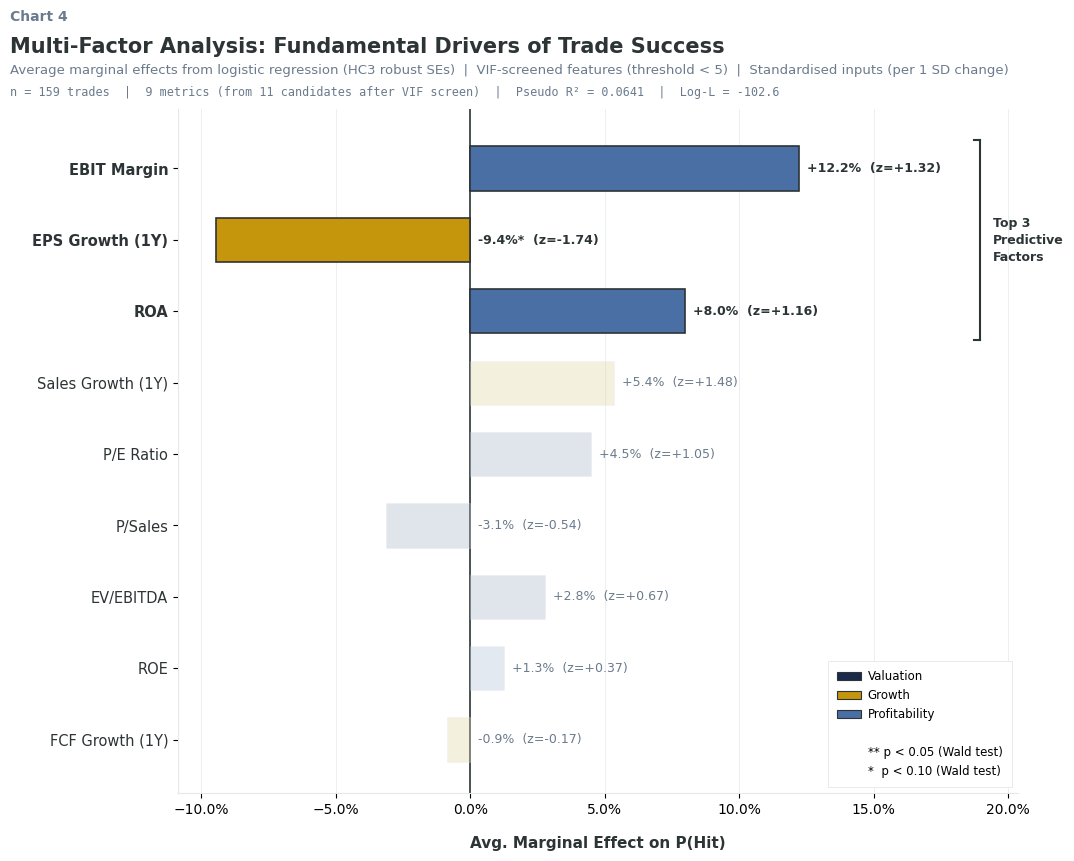

In [34]:
# --- institutional colour palette ---
NAVY     = '#1B2A4A'
STEEL    = '#4A6FA5'
GOLD_MF  = '#C5960C'
CHARCOAL = '#2D3436'
SLATE    = '#6B7B8D'
GRID_CLR = '#E5E7EB'

category_colors = {'Valuation': NAVY, 'Growth': GOLD_MF, 'Profitability': STEEL}
category_faded  = {'Valuation': '#A8B4C8', 'Growth': '#E2D5A3', 'Profitability': '#B0C0D4'}

fig, ax = plt.subplots(figsize=(14, 9))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

bar_height = 0.62
n = len(chart_df)

for i, (_, row) in enumerate(chart_df.iterrows()):
    is_top3 = abs(row['Marginal_Effect']) >= top3_cutoff
    is_sig10 = row['Significant_10pct']
    cat = row['Category']

    if is_top3:
        bar_color, bar_alpha = category_colors[cat], 1.0
        edge_color, edge_width = CHARCOAL, 1.2
    elif is_sig10:
        bar_color, bar_alpha = category_colors[cat], 0.50
        edge_color, edge_width = SLATE, 0.7
    else:
        bar_color, bar_alpha = category_faded[cat], 0.35
        edge_color, edge_width = GRID_CLR, 0.5

    ax.barh(i, row['Marginal_Effect'], height=bar_height,
            color=bar_color, alpha=bar_alpha,
            edgecolor=edge_color, linewidth=edge_width, zorder=3)

    me_val = row['Marginal_Effect']
    sig_marker = '**' if row['Significant_5pct'] else ('*' if row['Significant_10pct'] else '')
    label_weight = 'bold' if is_top3 else 'normal'
    label_color = CHARCOAL if is_top3 else SLATE
    label_text = f'{me_val:+.1%}{sig_marker}  (z={row["Wald_z"]:+.2f})'

    # always place labels on the positive side so negative bars
    # don't collide with the y-axis tick labels
    if me_val >= 0:
        ax.text(me_val + 0.003, i, label_text,
                va='center', ha='left', fontsize=9,
                fontweight=label_weight, color=label_color, zorder=4)
    else:
        ax.text(0.003, i, label_text,
                va='center', ha='left', fontsize=9,
                fontweight=label_weight, color=label_color, zorder=4)

# --- TOP 3 BRACKET ---
top3_indices = chart_df.index[chart_df['Marginal_Effect'].abs() >= top3_cutoff]
if len(top3_indices) >= 3:
    bracket_top = top3_indices.max() + 0.4
    bracket_bot = top3_indices.min() - 0.4
    x_max_val = chart_df['Marginal_Effect'].abs().max()
    bracket_x = x_max_val * 1.55

    ax.plot([bracket_x, bracket_x], [bracket_bot, bracket_top],
            color=CHARCOAL, linewidth=1.5, clip_on=False, zorder=5)
    ax.plot([bracket_x - 0.002, bracket_x], [bracket_bot, bracket_bot],
            color=CHARCOAL, linewidth=1.5, clip_on=False, zorder=5)
    ax.plot([bracket_x - 0.002, bracket_x], [bracket_top, bracket_top],
            color=CHARCOAL, linewidth=1.5, clip_on=False, zorder=5)

    ax.text(bracket_x + 0.005, (bracket_top + bracket_bot) / 2,
            'Top 3\nPredictive\nFactors',
            va='center', ha='left', fontsize=9, fontweight='bold',
            color=CHARCOAL, linespacing=1.4, clip_on=False, zorder=5)

# --- AXES ---
ax.set_yticks(range(n))
ax.set_yticklabels(chart_df['Display'], fontsize=10.5, color=CHARCOAL)

for i, label in enumerate(ax.get_yticklabels()):
    if i in top3_indices:
        label.set_fontweight('bold')

ax.axvline(x=0, color=CHARCOAL, linewidth=1.2, zorder=2)
ax.grid(axis='x', color=GRID_CLR, linewidth=0.5, zorder=1)
ax.grid(axis='y', visible=False)
ax.set_xlabel('Avg. Marginal Effect on P(Hit)',
              fontsize=11, fontweight='bold', color=CHARCOAL, labelpad=14)
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(GRID_CLR)
ax.spines['bottom'].set_color(GRID_CLR)

# --- TITLE ---
fig.text(0.06, 0.97, 'Chart 4', fontsize=10, fontweight='bold',
         color=SLATE, va='top')
fig.text(0.06, 0.94,
         'Multi-Factor Analysis: Fundamental Drivers of Trade Success',
         fontsize=15, fontweight='bold', color=CHARCOAL, va='top')
fig.text(0.06, 0.91,
         'Average marginal effects from logistic regression (HC3 robust SEs)  |  '
         f'VIF-screened features (threshold < 5)  |  '
         'Standardised inputs (per 1 SD change)',
         fontsize=9.5, color=SLATE, va='top')

# --- LEGEND ---
surviving_cats = set(metrics_config[c][0] for c in surviving_cols)
legend_elements = []
if 'Valuation' in surviving_cats:
    legend_elements.append(Patch(facecolor=NAVY, edgecolor=CHARCOAL, linewidth=0.8, label='Valuation'))
if 'Growth' in surviving_cats:
    legend_elements.append(Patch(facecolor=GOLD_MF, edgecolor=CHARCOAL, linewidth=0.8, label='Growth'))
if 'Profitability' in surviving_cats:
    legend_elements.append(Patch(facecolor=STEEL, edgecolor=CHARCOAL, linewidth=0.8, label='Profitability'))
legend_elements.extend([
    Line2D([0], [0], color='none', label=''),
    Line2D([0], [0], color='none', label='** p < 0.05 (Wald test)'),
    Line2D([0], [0], color='none', label='*  p < 0.10 (Wald test)'),
])
leg = ax.legend(handles=legend_elements, loc='lower right', fontsize=8.5,
                frameon=True, fancybox=False, edgecolor=GRID_CLR,
                framealpha=1.0, borderpad=0.8, handletextpad=0.6)
leg.get_frame().set_linewidth(0.6)

# --- MODEL DIAGNOSTICS in subtitle area ---
pseudo_r2 = logit_results.prsquared
ll = logit_results.llf
n_obs = int(logit_results.nobs)

fig.text(0.06, 0.885,
         f'n = {n_obs} trades  |  {len(surviving_cols)} metrics '
         f'(from {len(feature_cols)} candidates after VIF screen)  |  '
         f'Pseudo R² = {pseudo_r2:.4f}  |  Log-L = {ll:.1f}',
         fontsize=8.5, color=SLATE, va='top', fontfamily='monospace')

plt.subplots_adjust(top=0.86, bottom=0.10, left=0.18, right=0.78)
plt.savefig('chart4_multifactor_institutional.png', dpi=300,
            bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

### 5.8 Multi-Factor Summary

In [35]:
print("\n" + "=" * 70)
print("MULTI-FACTOR MODEL SUMMARY")
print("=" * 70)
print(f"  Model: Logistic Regression with HC3 robust standard errors")
print(f"  Observations: {n_obs} complete trades")
print(f"  Candidate features: {len(feature_cols)}")
print(f"  After VIF screening (threshold < {VIF_THRESHOLD}): {len(surviving_cols)}")
print(f"  Pseudo R²: {pseudo_r2:.4f}")

if dropped_features:
    print(f"\n  Dropped for multicollinearity:")
    for d in dropped_features:
        print(f"    {d['Display']} (VIF = {d['VIF']:.1f})")

print(f"\n  Top 3 factors by |marginal effect|:")
top3 = chart_df.loc[chart_df['Marginal_Effect'].abs().nlargest(3).index]
for _, r in top3.iterrows():
    sig = '**' if r['Significant_5pct'] else ('*' if r['Significant_10pct'] else 'ns')
    print(f"    {r['Display']:.<25} ME = {r['Marginal_Effect']:+.1%}  "
          f"z = {r['Wald_z']:+.2f}  p = {r['Coef_PValue']:.4f}  [{sig}]")

print(f"\n  Metrics significant at 5%:  "
      f"{chart_df['Significant_5pct'].sum()}/{len(chart_df)}")
print(f"  Metrics significant at 10%: "
      f"{chart_df['Significant_10pct'].sum()}/{len(chart_df)}")
print("=" * 70)


MULTI-FACTOR MODEL SUMMARY
  Model: Logistic Regression with HC3 robust standard errors
  Observations: 159 complete trades
  Candidate features: 11
  After VIF screening (threshold < 5): 9
  Pseudo R²: 0.0641

  Dropped for multicollinearity:
    P/B Ratio (VIF = 15.1)
    ROIC (VIF = 6.3)

  Top 3 factors by |marginal effect|:
    EBIT Margin.............. ME = +12.2%  z = +1.32  p = 0.1862  [ns]
    EPS Growth (1Y).......... ME = -9.4%  z = -1.74  p = 0.0822  [*]
    ROA...................... ME = +8.0%  z = +1.16  p = 0.2447  [ns]

  Metrics significant at 5%:  0/9
  Metrics significant at 10%: 1/9
